# 1. Imports

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Definições

In [32]:
IMAGES_PATH = "../reports/figures/images/"
PATH_INPUT_DATASET = '../data/processed/internacoes_processado.csv'

# 3. Funções de apoio

In [31]:

def salvar_figura(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def obter_nomes_colunas_por_tipo(df, numeric=False):
    if numeric:
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    else:
        return list(df.select_dtypes(include=['object']).columns)

def plotar_features_categoricas(df, target_column, categorical_features):
    for feature in categorical_features:
        sns.countplot(x=feature, data=df, hue=target_column)
        plt.show()
        plt.clf()
    plt.tight_layout()

In [33]:
df = pd.read_csv(PATH_INPUT_DATASET)

df.head()

,sexo,estado_civil,etnia,arranjo_domiciliar,traumatismo,prob_respiratorios,avc,convulsao,has,diabetes,doenca_infecto,situacao_profissao,cid_diagnostico_grupo_chave,ano_data_internacao,mes_data_internacao,idade_data_internacao,tempo_internacao_horas,reinternacao
0,F,solteiro,branco,sozinho,0,0,0,0,0,0,0,inativa,CID_GRP_25,2012,8,23,670.500000,1
1,M,nao informado,preto,nao informado,0,0,0,0,0,0,0,nao informada,CID_GRP_28,2012,8,22,24.266667,1
2,F,nao informado,nao informado,nao informado,0,0,0,0,0,0,0,ativa,CID_GRP_19,2012,8,32,2191.733333,0
3,F,solteiro,nao informado,nao informado,0,0,0,0,0,0,0,inativa,CID_GRP_25,2012,8,14,133.916667,0
4,F,casado,branco,acompanhado,0,0,0,0,0,0,0,nao informada,CID_GRP_23,2012,8,28,133.616667,1


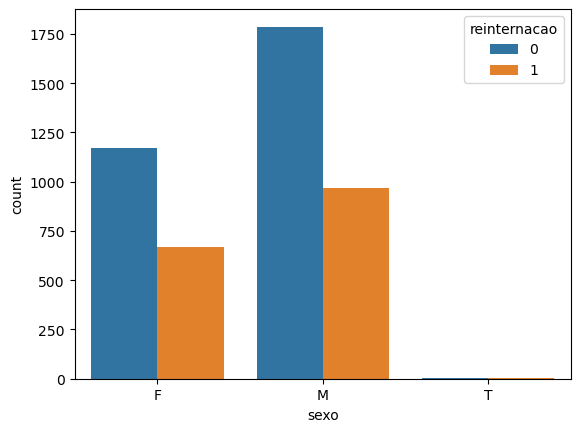

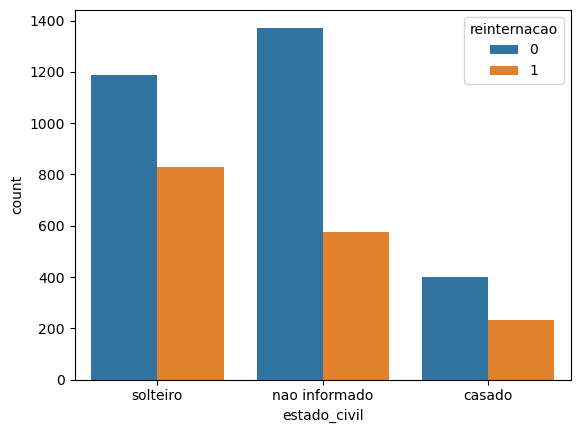

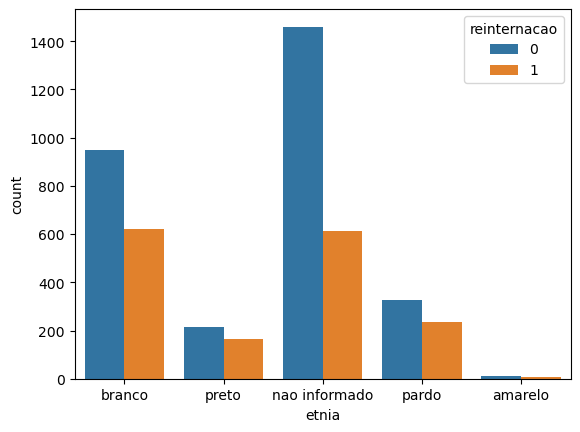

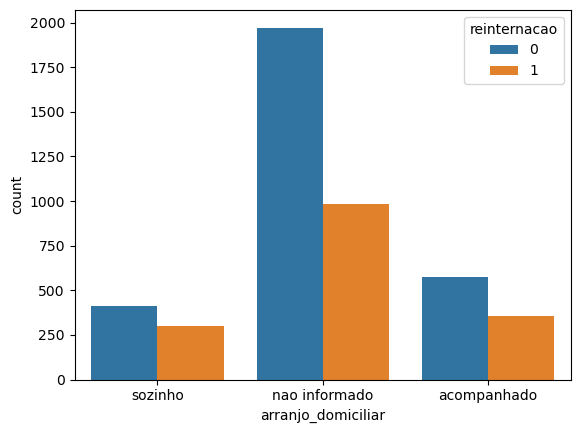

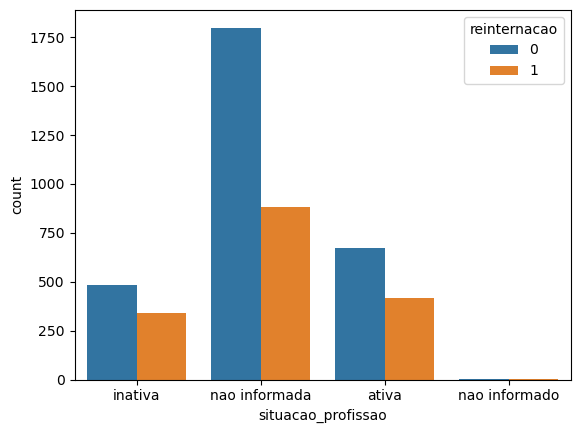

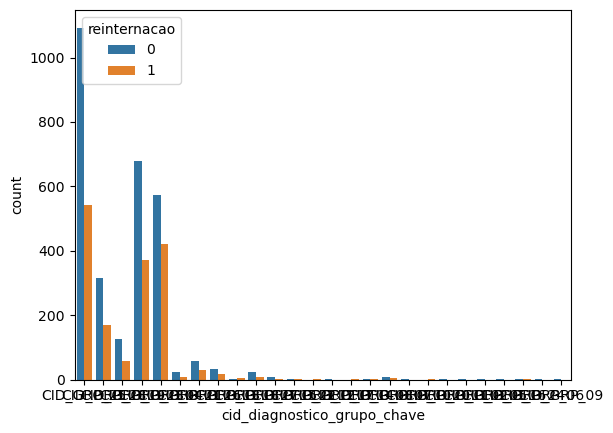

<Figure size 640x480 with 0 Axes>

In [35]:
plotar_features_categoricas(df, "reinternacao", obter_nomes_colunas_por_tipo(df, numeric=False))


In [38]:
df.columns

Index(['sexo', 'estado_civil', 'etnia', 'arranjo_domiciliar', 'traumatismo',
       'prob_respiratorios', 'avc', 'convulsao', 'has', 'diabetes',
       'doenca_infecto', 'situacao_profissao', 'cid_diagnostico_grupo_chave',
       'ano_data_internacao', 'mes_data_internacao', 'idade_data_internacao',
       'tempo_internacao_horas', 'reinternacao'],
      dtype='object')

<AxesSubplot:xlabel='mes_data_internacao', ylabel='count'>

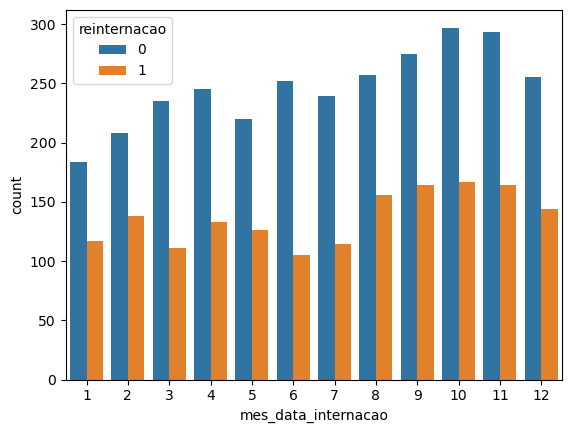

In [42]:
sns.countplot(x="mes_data_internacao", data=df, hue="reinternacao")